# Movie Search Blog
## Part 3: Search
In this post, we populate an Amazon OpenSearch Service domain with movie indexes. 

We use Neptune ML (https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning.html) Graph Neural Networks (GNN) to encode embeddings for movies in the IMDB dataset. Our goal is to produce a graph-aware embedding that represents a movie plus related entities, such as genres and artists. 

Here is our overall movie data model:

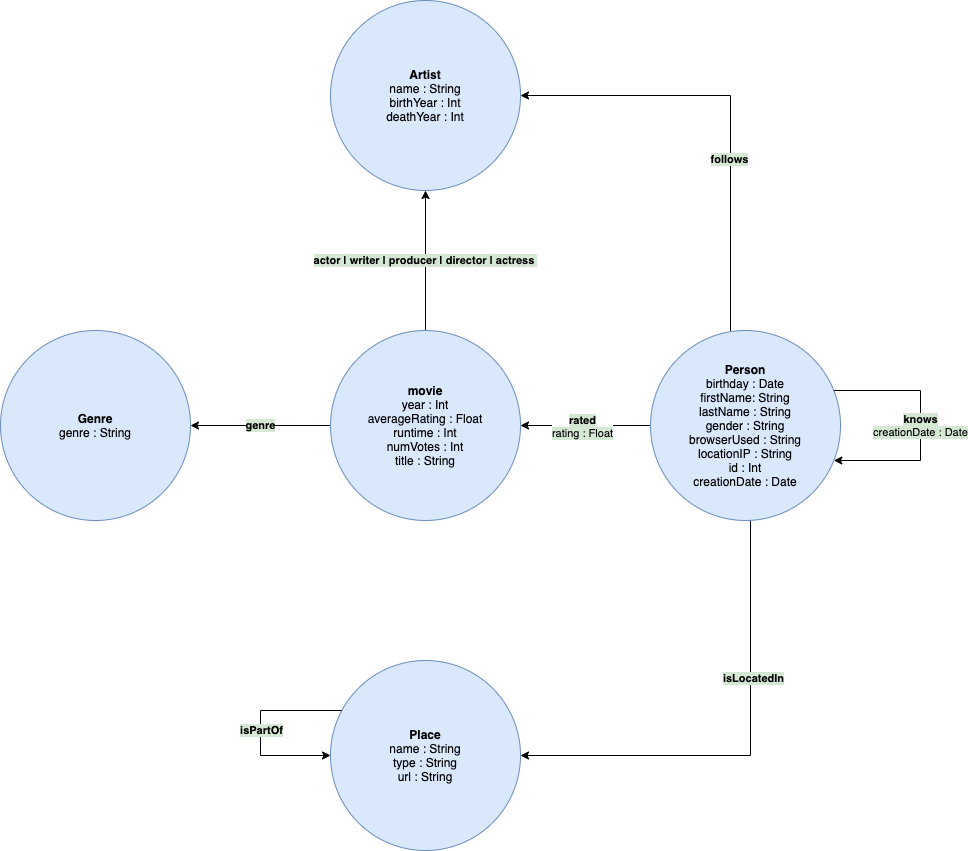

The following diagram depicts the approach. For more discussion, refer to our blog post.

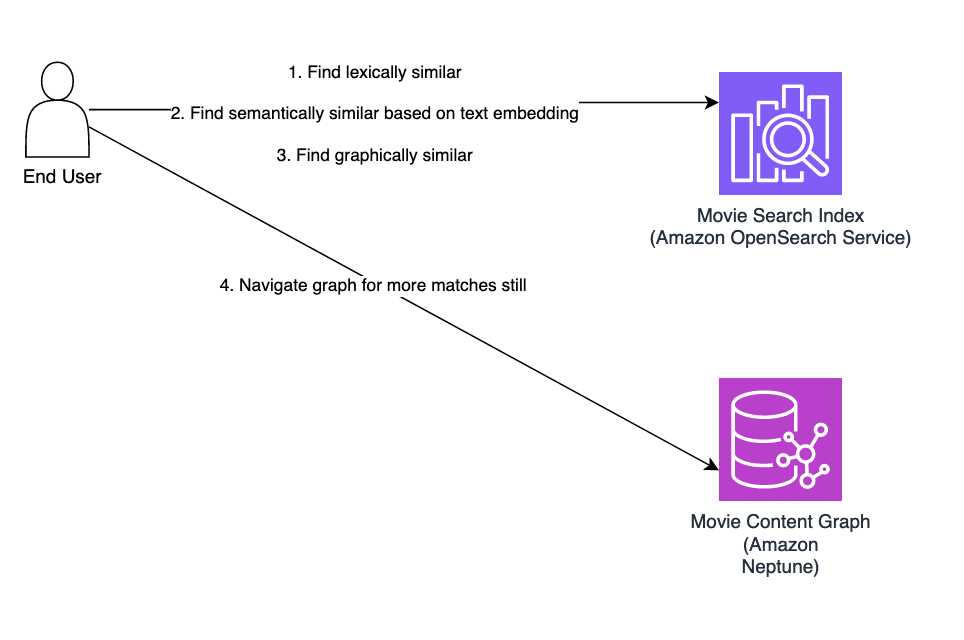


## Exploring our search results
In the remainder of this notebook we will be exploring the results of the search compontents we have been assembling in the first two noteboks.

## Settings

First we will need to import the boto3 utility to extract some of our enviornment variables. We will also need to assign the variable `AOS_ENDPOINT` to your Amazon OpenSearch endpoint you have been using.

In [ ]:
import boto3

REGION = boto3.Session().region_name
# Insert your Amazon OpenSearch endpoint below in place of the red placeholder string 
AOS_ENDPOINT="<your AOS endpoint>"


## Connect to OpenSearch domain

We will now need to connect to the Amazon OpenSearch domain we have been working with in order to execute our queries.

In [ ]:
!pip install -q opensearch-py

In [ ]:
import boto3
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth

aos_client = OpenSearch(
    hosts = [{'host': AOS_ENDPOINT.split("//")[1], 'port': 443}],
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection
)


In [ ]:
aos_client.indices.get_alias(index="*")

### Sentence transformer model

The cell below will align utilities for us to work with the embeddings we have created.

In [ ]:
pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def get_embeddings(sentences):
    embeddings = model.encode(sentences)
    return embeddings
    
def get_str_embedding(embedding):
    return ';'.join([str(x) for x in embedding])

def parse_str_embedding(s):
    toks= s.split(";")
    return list(map(lambda x: float(x), toks))
    


## Fuzzy query on title

Lets first explore a standard lexical search on the first index we created. This index does not utilize embeddings but instead does a fuzzy match on the title input. Here, we will use the sample search text "Poseidon"

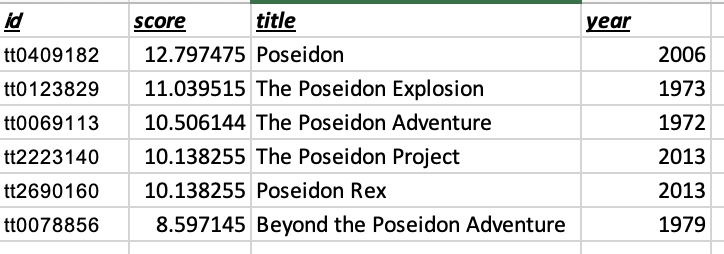


In [ ]:
def get_field(h, fname):
    if fname in h['_source']:
        return h['_source'][fname]
    else:
        return ""
    

In [ ]:
search_text="Posidon"
query = {
    "size": 30,
    "query": {
        "match": {
            "title": { 
                "query": search_text,
                "fuzziness": "AUTO"
            }
        }
    }
}
lex_result = aos_client.search(index="movie", body=query)
print(f"Lexical results: {search_text}")
print("id|score|title|year")
for idx, h in enumerate(lex_result["hits"]["hits"]):
    print(f"{h['_id']}|{h['_score']}|{get_field(h, 'title')}|{get_field(h, 'year')}")
    

## Semantic query on sentence embedding

For this next search we will now use the second OpenSearch index that we created. This index utilized the sentance embeddings which we generated from our sentance transformer model. We will once again use the input text "Poseidon" here. Notice the output and compare it with the output from our first search above.

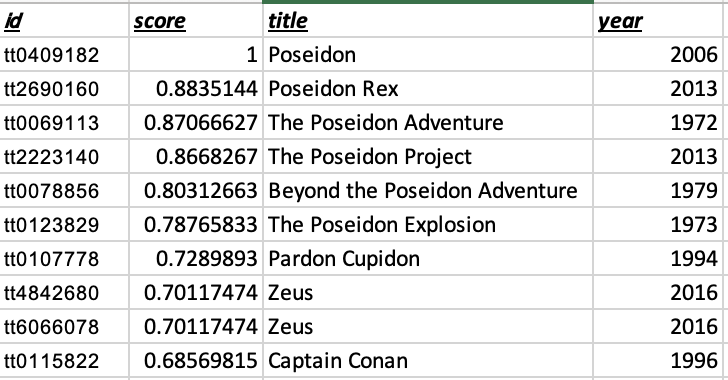

In [ ]:
search_text="Poseidon"
search_vector=get_embeddings(search_text).tolist()

query={
    "size": 30,
    "query": {
        "knn": {
            "sentence_embedding":{
                "vector":search_vector,
                "k":20
            }
        }
    }
}

sem_result = aos_client.search(index="movie_sentence",  body=query)
print(f"Semantic/sentence embedding results: {search_text}")
print("id|score|title|year")
for idx, h in enumerate(sem_result["hits"]["hits"]):
    print(f"{h['_id']}|{h['_score']}|{get_field(h, 'title')}|{get_field(h, 'year')}")


### Combined score

Scores for 'Poseidon'

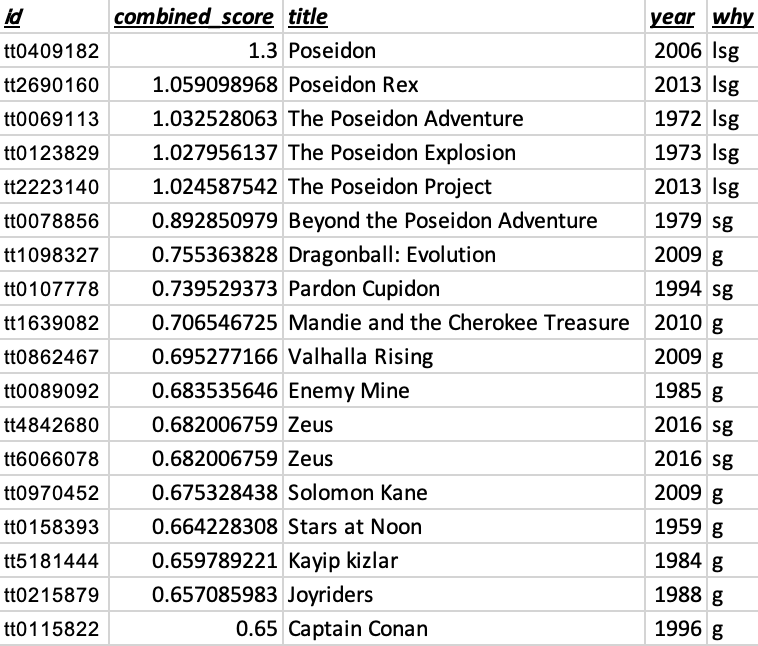

In [ ]:
# top-level lexical query
query = {
    "size": 30,
    "query": {
        "match": {
            "title": { 
                "query": search_text,
                "fuzziness": "AUTO"
            }
        }
    }
}

# top-level semantic query on sentence index
search_vector=get_embeddings(search_text).tolist()
squery={
    "size": 30,
    "query": {
        "knn": {
            "sentence_embedding":{
                "vector":search_vector,
                "k":30
            }
        }
    }
}

#
# Calculations needed for combined score
#

# Normalized score of s relative to mininum (mn) and maxinum (mx) scores
def norm(s, mn, mx):
    if s == mn and mn == mx:
        return s
    return (s-mn)/(mx-mn)

# A combined score across lexical (l), sentence (s), and gnn (g) scores. 
# The score is the weighted maximum.
# Use weights wl, ws, wg. Adjust these parameters if needed.
# Note that gnn score is not direct but in terms of a parent: lex or semantic.
# We first find movie and its GNN embedding from a lex or sentence search. 
# Then we compare other it to GNN embeddings of other movies.
def combine(l, s, parent_g, g, wl=1.0, ws=1.2, wg=1.3):
    return max(l*wl, s*ws, (parent_g+g)*wg/2.0)


#
# Movie results structure used to build initial result (prior to combined scoring)
#

SEARCH_LEX="lex"
SEARCH_SENTENCE="sentence"
SEARCH_GNN="gnn"
movie_results = {}

# process the results (res) for search_type (SEARCH_LEX, SEARCH_SENTENCE, SEARCH_GNN)
# put results in movie_results dictionary
# Note GNN has a parent movie ID
def process_results(res, search_type, parent=None):
    # initialize min score
    max_score = res['hits']['max_score']
    min_score = max_score
    
    # loop through the results set
    for idx, h in enumerate(res["hits"]["hits"]):
        mid = h['_id']
        movie_record = movie_results[mid] if mid in movie_results else None
        if movie_record is None:
            # create movie record for movie ID 
            movie_record = {
                'id': mid,
                'gnn_embedding': h['_source']['gnn_embedding'],
                'title': get_field(h, 'title'),
                'year': get_field(h, 'year'),
                'gnn_per_parent': {}
            }
            movie_results[mid] = movie_record
            
        if parent is None:
            # local score for lex or sentence
            # there can be at most one result per movie in lex or sentence results
            movie_record[search_type] = {
                'local_score': h['_score']
            }
        else:
            # local score for GNN. There can be multiple GNN movie hits
            movie_record[search_type] = {
                'norm_score': 0.0
            }        
            movie_record['gnn_per_parent'][parent] = {
                'local_score': h['_score']
            }

        #update min score
        min_score = min(min_score, h['_score'])
        
    # normalize
    for idx, h in enumerate(res["hits"]["hits"]):
        mid = h['_id']
        movie_record = movie_results[mid]
        if parent is None:
            # normalized lex or sentence score
            movie_record[search_type]['norm_score'] = norm(
                movie_record[search_type]['local_score'],
                min_score, 
                max_score
            )
        else:
            # normalized GNN score; depends on parent score too
            movie_record['gnn_per_parent'][parent]['norm_score'] = norm(
                movie_record['gnn_per_parent'][parent]['local_score'],
                min_score, 
                max_score
            )
            if movie_record['gnn_per_parent'][parent]['norm_score'] >= movie_record[search_type]['norm_score']:
                # Keep track of best GNN movie score and which parent it was
                movie_record[search_type]['norm_score'] = movie_record['gnn_per_parent'][parent]['norm_score']
                movie_record[search_type]['parent'] = parent

# Run the score combine algorithm on each normalized score
def calc_combined_scores():
    def _norm(m, st):
        return movie_results[m][st]['norm_score'] if st in movie_results[m] else 0.0
    results = []
    for m in movie_results:
        contrib=""
        lex_score = _norm(m, SEARCH_LEX)
        if lex_score > 0.0:
            contrib+= "l"
        sent_score = _norm(m, SEARCH_SENTENCE)
        if sent_score > 0.0:
            contrib+= "s"
        gnn_score = 0.0
        parent_score = 0.0
        if SEARCH_GNN in movie_results[m]:
            gnn_score = _norm(m, SEARCH_GNN)
            if gnn_score > 0.0:
                contrib+= "g"
            parent = movie_results[m][SEARCH_GNN]['parent']
            parent_score = max(_norm(parent, SEARCH_LEX), _norm(parent, SEARCH_SENTENCE))
        results.append({
            'id': m,
            'title': movie_results[m]['title'],
            'year': movie_results[m]['year'],
            'score': combine(lex_score, sent_score, parent_score, gnn_score),
            'working': [lex_score, sent_score, parent_score, gnn_score],
            'contrib': contrib
        })
        
    def order_key(e):
        return e['score']
        
    # results sorted in descending order of combined score
    results.sort(key=order_key, reverse=True)
    return results
        
# get search results for lex and sentence
process_results(aos_client.search(index="movie", body=query), SEARCH_LEX)
process_results(aos_client.search(index='movie_sentence', body=squery), SEARCH_SENTENCE)

# for each movie in movie_results, get GNN search results
num_movies=len(movie_results)
for m in list(movie_results.keys()).copy():
    if 'gnn_embedding' in movie_results[m]:
        gquery = {
            "size": num_movies,
            "query": {
                "knn": {
                    "gnn_embedding": {
                        "vector": movie_results[m]['gnn_embedding'], 
                        "k": 10
                    }
                }
            }
        }
        process_results(aos_client.search(index='movie_gnn', body=gquery), SEARCH_GNN, m)

# Get combined scores and print top N
mlist = calc_combined_scores()
print("id|combined_score|title|year|why")
for m in mlist[0:20]:
    print(f"{m['id']}|{m['score']}|{m['title']}|{m['year']}|{m['contrib']}")

## Explain GNN results in Neptune

Among Poseidon results, we see that tt0409182 Poseidon has GNN match tt1098327 Dragonball: Evolution. Why?


In [ ]:
%%oc -d id

MATCH path=(m:movie)-[e:actor|actress|producer|director|writer|genre|rated*1..3]-(m2:movie)                       
WHERE id(m)='tt0409182' and id(m2)='tt1098327'
RETURN path
LIMIT 30

In [ ]:
%%oc -d id

MATCH (m:movie)-[ma:actor|actress]->(a:Artist),
(m:movie)-[mg:genre]->(g:Genre)
WHERE id(m)='tt0409182' or id(m)='tt1098327'
RETURN m.title, m.year, collect(distinct g.genre) as genres, collect (distinct a.name) as cast 
